## Sequence Interpolation

This notebook focuses on distance sequence and enumeration distance sequence. Fixed and Dwelling seqeunces are generated using the property of the census data. Thus, they are not missing from all records. Distance and Enumeration Distance are shown to be important features in the model phase.

**Criterion**: interpolate dwellings with missing sequence if they are in between 2 dwellings of the same **block number**. 

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interpolation, CensusData, dataprocessing, sequences
from interpolation import disambiguation_analysis as da

In [2]:
census_enumerators = pd.read_csv('../../data/1850_census_enumerators_120820.csv')

In [3]:
ward_col = "CENSUS_WARD_NUM"
dwelling_col = "dwelling_id"
block_col = "CD_BLOCK_NUM"
cd_ward_col = "CD_WARD_NUM"
cd_block_col = "CD_BLOCK_NUM"
dwelling_num_col = "CENSUS_DWELLING_NUM"
cd_address = "CD_H_ADDRESS"
pagenum = "CENSUS_PAGENUM"
x_col = "CD_X"
y_col = "CD_Y"

## Generate sequences

In [4]:
census_enum_seq = CensusData(census_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, 
                                 fixed = True, distance = True, d=0.1)

d:  0.1


In [5]:
dist_seq_col = 'sequence_id'
dist_enum_col = 'enum_dist_id'

## Fill in sequences by looking at only sequences

In [6]:
census_all_dwellings = census_enum_seq.df.groupby([ward_col, dwelling_col], as_index = False).first()
dwellings_sequence = census_all_dwellings.dropna(subset=[dist_seq_col])

## 1. Get dwellings that are followed by no-sequence dwellings whose sequence can be interpolated
## dwellings_sequence => dwellings with current_seq_col not missing
dwelling_sequence_sames = interpolation.same_next(dwellings_sequence, column = dist_seq_col)
# dwelling_sequence_sames = dwellings_sequence.groupby(ward_col).agg(interpolation.same_next, block_col)

"""
2. Merge dwelling_sequence_sames back to all known dwelling df so that `BLOCK_NUM_next` and 
`num_between_real` are included in df of all known dwellings.
"""
dwellings_sequence_with_next_info = dwellings_sequence.merge(dwelling_sequence_sames[[ward_col, dwelling_col,
                                                                        dist_seq_col+'_next', 
                                                                                      'num_between_real',
                                                                                      'header']], 
                                                             on=[ward_col, dwelling_col], how='left')

## only check on sequence col
all_dwellings_1_dist = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = dist_seq_col,
                                                       check_column = [dist_seq_col], ward_col = ward_col, dwelling_col = dwelling_col)
## remove the other sequence col. To be filled later.
all_dwellings_1_dist.drop(columns=[dist_enum_col], inplace=True)

In [7]:
census_all_dwellings = census_enum_seq.df.groupby([ward_col, dwelling_col], as_index = False).first()
dwellings_sequence = census_all_dwellings.dropna(subset=[dist_enum_col])

## 1. Get dwellings that are followed by no-sequence dwellings whose sequence can be interpolated
## dwellings_sequence => dwellings with current_seq_col not missing
dwelling_sequence_sames = interpolation.same_next(dwellings_sequence, column = dist_enum_col)
# dwelling_sequence_sames = dwellings_sequence.groupby(ward_col).agg(interpolation.same_next, block_col)

"""
2. Merge dwelling_sequence_sames back to all known dwelling df so that `BLOCK_NUM_next` and 
`num_between_real` are included in df of all known dwellings.
"""
dwellings_sequence_with_next_info = dwellings_sequence.merge(dwelling_sequence_sames[[ward_col, dwelling_col,
                                                                        dist_enum_col+'_next', 
                                                                                      'num_between_real',
                                                                                      'header']], 
                                                             on=[ward_col, dwelling_col], how='left')

## only check on sequence col
all_dwellings_1_enum = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = dist_enum_col,
                                                       check_column = [dist_enum_col], ward_col = ward_col,
                                                              dwelling_col = dwelling_col)
## remove the other sequence col. To be filled later.
all_dwellings_1_enum = all_dwellings_1_enum[[dwelling_col, dist_enum_col]]

In [8]:
all_dwellings_1 = all_dwellings_1_dist.copy()
all_dwellings_1[dist_enum_col] = all_dwellings_1_enum[dist_enum_col]
print(all_dwellings_1.shape)
print(all_dwellings_1_dist.shape)
print(all_dwellings_1_enum.shape)

(38560, 50)
(38560, 49)
(38560, 2)


## Fill in sequences by looking at sequences and block number

In [9]:
census_all_dwellings = census_enum_seq.df.groupby([ward_col, dwelling_col], as_index = False).first()
dwellings_sequence = census_all_dwellings.dropna(subset=[dist_seq_col])

## 1. Get dwellings that are followed by no-sequence dwellings whose sequence can be interpolated
## dwellings_sequence => dwellings with current_seq_col not missing
dwelling_sequence_sames = interpolation.same_next(dwellings_sequence, column = dist_seq_col)
# dwelling_sequence_sames = dwellings_sequence.groupby(ward_col).agg(interpolation.same_next, block_col)

"""
2. Merge dwelling_sequence_sames back to all known dwelling df so that `BLOCK_NUM_next` and 
`num_between_real` are included in df of all known dwellings.
"""
dwellings_sequence_with_next_info = dwellings_sequence.merge(dwelling_sequence_sames[[ward_col, dwelling_col,
                                                                        dist_seq_col+'_next', 
                                                                                      'num_between_real',
                                                                                      'header']], 
                                                             on=[ward_col, dwelling_col], how='left')

## only check on sequence col
all_dwellings_2_dist = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = dist_seq_col,
                                                       check_column = [block_col, dist_seq_col], ward_col = ward_col, 
                                                              dwelling_col = dwelling_col)
## remove the other sequence col. To be filled later.
all_dwellings_2_dist.drop(columns=[dist_enum_col], inplace=True)

In [10]:
census_all_dwellings = census_enum_seq.df.groupby([ward_col, dwelling_col], as_index = False).first()
dwellings_sequence = census_all_dwellings.dropna(subset=[dist_enum_col])

## 1. Get dwellings that are followed by no-sequence dwellings whose sequence can be interpolated
## dwellings_sequence => dwellings with current_seq_col not missing
dwelling_sequence_sames = interpolation.same_next(dwellings_sequence, column = dist_enum_col)
# dwelling_sequence_sames = dwellings_sequence.groupby(ward_col).agg(interpolation.same_next, block_col)

"""
2. Merge dwelling_sequence_sames back to all known dwelling df so that `BLOCK_NUM_next` and 
`num_between_real` are included in df of all known dwellings.
"""
dwellings_sequence_with_next_info = dwellings_sequence.merge(dwelling_sequence_sames[[ward_col, dwelling_col,
                                                                        dist_enum_col+'_next', 
                                                                                      'num_between_real',
                                                                                      'header']], 
                                                             on=[ward_col, dwelling_col], how='left')

## only check on sequence col
all_dwellings_2_enum = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = dist_enum_col,
                                                       check_column = [block_col, dist_enum_col], ward_col = ward_col,
                                                              dwelling_col = dwelling_col)
## remove the other sequence col. To be filled later.
all_dwellings_2_enum = all_dwellings_2_enum[[dwelling_col, dist_enum_col]]

In [11]:
all_dwellings_2 = all_dwellings_2_dist.copy()
all_dwellings_2[dist_enum_col] = all_dwellings_2_enum[dist_enum_col]
print(all_dwellings_2.shape)
print(all_dwellings_2_dist.shape)
print(all_dwellings_2_enum.shape)

(38560, 50)
(38560, 49)
(38560, 2)


In [12]:
dist_seq_col = 'sequence_id'
dist_enum_col

'enum_dist_id'

In [13]:
col_list = [ward_col, block_col, dwelling_col, dist_seq_col, dist_enum_col]
result_seq = all_dwellings_1[col_list].merge(all_dwellings_2[col_list], suffixes=['_1', '_2'], 
                                             on=[ward_col, block_col, dwelling_col])

In [14]:
result_seq

,CENSUS_WARD_NUM,CD_BLOCK_NUM,dwelling_id,sequence_id_1,enum_dist_id_1,sequence_id_2,enum_dist_id_2
0,1,mn1850_01_74.0091_40.7028,1,0.0,0.0,0.0,0.0
1,1,NaN,2,NaN,NaN,NaN,NaN
2,1,NaN,3,NaN,NaN,NaN,NaN
3,1,NaN,4,NaN,NaN,NaN,NaN
4,1,NaN,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
38555,19,NaN,1770,NaN,NaN,NaN,NaN
38556,19,NaN,1771,NaN,NaN,NaN,NaN
38557,19,NaN,1772,NaN,NaN,NaN,NaN
38558,19,NaN,1773,NaN,NaN,NaN,NaN


## Result

## Proportion increased by wards

In [15]:
total_num_dwellings = census_all_dwellings.groupby(ward_col)[dwelling_col].agg('nunique')
known_dist_num_dwellings = census_all_dwellings.loc[~census_all_dwellings[dist_seq_col].isnull()].groupby(ward_col)[dwelling_col].agg('nunique')
known_distenum_num_dwellings = census_all_dwellings.loc[~census_all_dwellings[dist_enum_col].isnull()].groupby(ward_col)[dwelling_col].agg('nunique')

In [16]:
def get_increase_prop(filled_df, filled_col, known_dwelling_by_ward, total_dwelling_by_ward):
    assigned = filled_df.loc[~filled_df[filled_col].isnull()].groupby(ward_col)[dwelling_col].agg('nunique')
    additional_assigned = assigned - known_dwelling_by_ward
    return additional_assigned/total_dwelling_by_ward

In [17]:
increase_prop_dist_1 = get_increase_prop(result_seq, 'sequence_id_1', known_dist_num_dwellings, total_num_dwellings)
increase_prop_distenum_1 = get_increase_prop(result_seq, 'enum_dist_id_1', known_distenum_num_dwellings, total_num_dwellings)

increase_prop_dist_2 = get_increase_prop(result_seq, 'sequence_id_2', known_dist_num_dwellings, total_num_dwellings)
increase_prop_distenum_2 = get_increase_prop(result_seq, 'enum_dist_id_2', known_distenum_num_dwellings, total_num_dwellings)

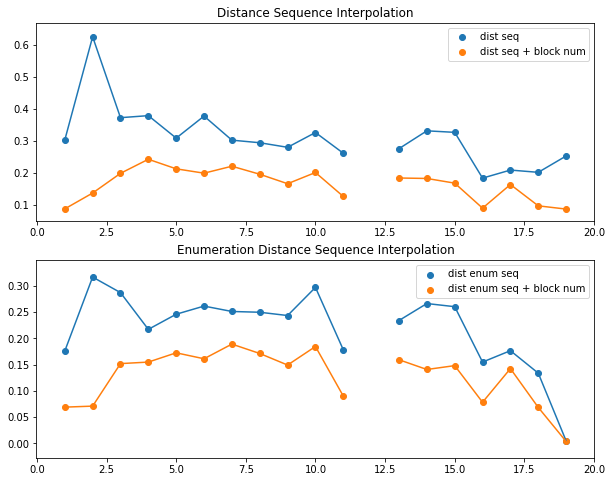

In [18]:
fig, ax = plt.subplots(2,1, figsize=(10, 8))

ax[0].scatter(increase_prop_dist_1.index, increase_prop_dist_1.values, label='dist seq')
ax[0].plot(increase_prop_dist_1.index, increase_prop_dist_1.values)
ax[0].scatter(increase_prop_dist_2.index, increase_prop_dist_2.values, label='dist seq + block num')
ax[0].plot(increase_prop_dist_2.index, increase_prop_dist_2.values)
ax[0].set_title('Distance Sequence Interpolation')
ax[0].legend()

ax[1].scatter(increase_prop_distenum_1.index, increase_prop_distenum_1.values, label='dist enum seq')
ax[1].plot(increase_prop_distenum_1.index, increase_prop_distenum_1.values)
ax[1].scatter(increase_prop_distenum_2.index, increase_prop_distenum_2.values, label='dist enum seq + block num')
ax[1].plot(increase_prop_distenum_2.index, increase_prop_distenum_2.values)
ax[1].set_title('Enumeration Distance Sequence Interpolation')
ax[1].legend()


### Conclusion

* Generally, recovering rate of distance sequence is higher than of enumeration distance sequence because the latter sequence breaks more often. As a result, it is less likely for unknown dwellings to be in between the same enumeration distance sequence.
* Restricting the interpolation of distance sequence on also block number reduces the rate by close to half. 

## Take a look at where they differ

In [19]:
temp = result_seq.replace(np.nan, -1)
np.where(temp['sequence_id_1'] != temp['sequence_id_2'])

(array([   17,    18,    19, ..., 38454, 38456, 38457]),)

In [21]:
result_seq.iloc[15:50]

,CENSUS_WARD_NUM,CD_BLOCK_NUM,dwelling_id,sequence_id_1,enum_dist_id_1,sequence_id_2,enum_dist_id_2
15,1,NaN,16,NaN,NaN,NaN,NaN
16,1,mn1850_01_74.0103_40.7064,17,38.0,16.0,38.0,16.0
17,1,NaN,18,38.0,NaN,NaN,NaN
18,1,NaN,19,38.0,NaN,NaN,NaN
19,1,NaN,20,38.0,NaN,NaN,NaN
20,1,NaN,21,38.0,NaN,NaN,NaN
21,1,NaN,22,38.0,NaN,NaN,NaN
22,1,NaN,23,38.0,NaN,NaN,NaN
23,1,NaN,24,38.0,NaN,NaN,NaN
24,1,NaN,25,38.0,NaN,NaN,NaN


## Note

* When moving to the model phase, we should look at **block cluster**, rather than block number. More analysis needs to be done.